In [1]:
# 데이터 로드 코드

import numpy as np

# hybrid feature와 label 저장
# np.savez_compressed(
#     "train_hybrid_data.npz",  # 저장 파일 이름
#     X_train_hybrid=X_train_hybrid,
#     y_train=y_train,
# )

# hybrid feature와 label 불러오기
with np.load("train_hybrid_data.npz") as data:
    X_train_hybrid = data["X_train_hybrid"]
    y_train = data["y_train"]

# 모델 학습 코드
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# ✅ 데이터 분리
X_train, X_val, y_train_split, y_val = train_test_split(
    X_train_hybrid, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# ✅ base 모델 정의
base_models = [
    (
        "lr",
        LogisticRegression(
            max_iter=1000, solver="lbfgs", multi_class="multinomial", C=0.5
        ),
    ),
    ("rf", RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
    (
        "lgb",
        LGBMClassifier(
            n_estimators=400,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
        ),
    ),
]

meta_model = LogisticRegression(
    max_iter=2000, solver="lbfgs", C=0.3, multi_class="multinomial"
)

# ✅ base 모델 개별 학습 진행상황 표시
print("🚀 Base model training started…\n")

for name, model in tqdm(
    base_models, desc="Training base models", total=len(base_models)
):
    model.fit(X_train, y_train_split)

print("\n✅ Base model training finished!\n")

# ✅ StackingClassifier 생성
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    stack_method="predict_proba",
    cv=3,  # 구조는 그대로 유지
    n_jobs=-1,
)

# ✅ 전체 스태킹 학습 진행 상황 표시
print("🚀 Stacking training started…\n")

with tqdm(total=1, desc="Fitting stacking model") as pbar:
    stacking_model.fit(X_train, y_train_split)
    pbar.update(1)

print("\nTraining finished successfully!")

🚀 Base model training started…



Training base models:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Training base models:  67%|██████▋   | 2/3 [03:18<01:49, 109.30s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196972
[LightGBM] [Info] Number of data points in the train set: 45981, number of used features: 779
[LightGBM] [Info] Start training from score -1.052457
[LightGBM] [Info] Start training from score -1.073231
[LightGBM] [Info] Start training from score -1.174353


Training base models: 100%|██████████| 3/3 [03:59<00:00, 79.68s/it] 



✅ Base model training finished!

🚀 Stacking training started…



Fitting stacking model:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
Fitting stacking model: 100%|██████████| 1/1 [06:05<00:00, 365.13s/it]


Training finished successfully!


c:\Users\user\anaconda3\envs\ML\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\ML\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 Validation Accuracy: 0.4776
📉 Validation LogLoss: 1.0280

Classification Report:
              precision    recall  f1-score   support

       A win       0.49      0.54      0.51      4013
       B win       0.49      0.51      0.50      3931
         Tie       0.44      0.38      0.41      3552

    accuracy                           0.48     11496
   macro avg       0.47      0.47      0.47     11496
weighted avg       0.48      0.48      0.48     11496



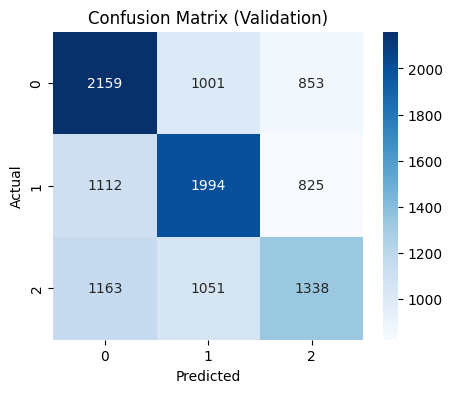

In [2]:
# 선제 위 코드 할려면 이거 임포트

from lightgbm import LGBMClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    log_loss,
)
import matplotlib.pyplot as plt
import seaborn as sns


# 성능 확인 코드

y_pred = stacking_model.predict(X_val)
y_prob = stacking_model.predict_proba(X_val)

acc = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_prob)

print(f"\n📊 Validation Accuracy: {acc:.4f}")
print(f"📉 Validation LogLoss: {loss:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["A win", "B win", "Tie"]))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
print(classification_report(y_val, y_val_pred, target_names=["A win", "B win", "Tie"]))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

NameError: name 'classification_report' is not defined